In [146]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [147]:
# To load the environment variable defined in the .env file
from dotenv import load_dotenv
load_dotenv();

In [148]:
import sys
import os
sys.path.append(os.path.join(os.environ['NHL_DATA_DIR'], '..'))

In [149]:
import numpy as np

import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import matplotlib.ticker as mtick


from sklearn.calibration import CalibrationDisplay
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, auc

import src.visualization.visualize as VizManager
import src.features.build_features as FeaturesManager

In [150]:
SEED = 42

In [151]:
seasons_year = [2015, 2016, 2017, 2018]
season_type = "Regular"
features_data = FeaturesManager.build_features(seasons_year, season_type)

# We take the absolute value, for symmetry reasons
features_data['Shot angle'] = features_data['Shot angle'].abs()

In [152]:
features_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 305860 entries, 0 to 305859
Data columns (total 29 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   Game ID                    305860 non-null  object 
 1   Event Index                305860 non-null  int64  
 2   Period                     305860 non-null  int64  
 3   Team                       305860 non-null  object 
 4   Type                       305860 non-null  object 
 5   Shot Type                  305827 non-null  object 
 6   Shooter                    305860 non-null  object 
 7   Goalie                     305860 non-null  object 
 8   Strength                   28689 non-null   object 
 9   X                          305860 non-null  float64
 10  Y                          305860 non-null  float64
 11  Last event type            305860 non-null  object 
 12  Last event X               302885 non-null  float64
 13  Last event Y               30

In [153]:
distance_data = features_data[['Shot distance', 'Is Goal']].dropna()
X = distance_data[['Shot distance']]
y = distance_data['Is Goal']

In [154]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=SEED, stratify=y)

In [155]:
clf = LogisticRegression(random_state=SEED).fit(X_train, y_train)

In [156]:
accuracy = clf.score(X_valid, y_valid)
print(f'Accuracy on validation set = {np.around(100.*accuracy, 2)}%')

Accuracy on validation set = 90.62%


In [157]:
import warnings
warnings.filterwarnings("ignore")

0.9061989145360623
Dumb Accuracy on validation set = 90.62%


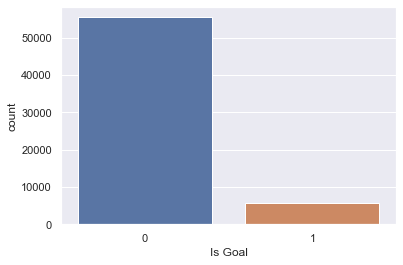

In [158]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

# Accuracy is not the right metric to use, as the classes are unbalanced
num_goals = y_valid[y_valid==1].count()
num_no_goals =  y_valid[y_valid==0].count()
print(num_no_goals / (num_no_goals+num_goals))
sns.countplot(y_valid);

# A dumb model that predicts 0 (no goals) all the time reach the same level of performance
def dumb_model(X, y):
    pred = np.zeros_like(X['Shot distance'])
    return (y == pred).mean() # ? why the mean?


dumb_accuracy = dumb_model(X_valid, y_valid)
print(f'Dumb Accuracy on validation set = {np.around(100.*dumb_accuracy, 2)}%')

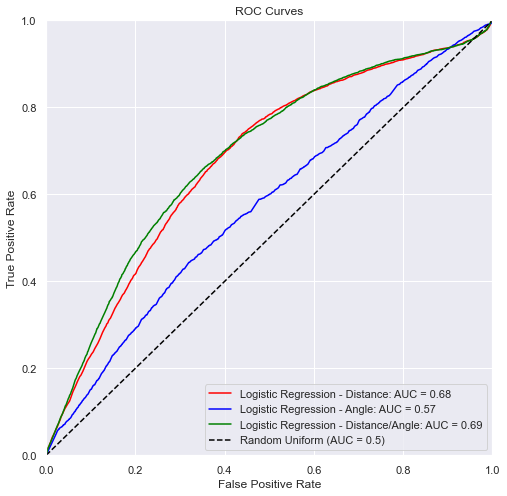

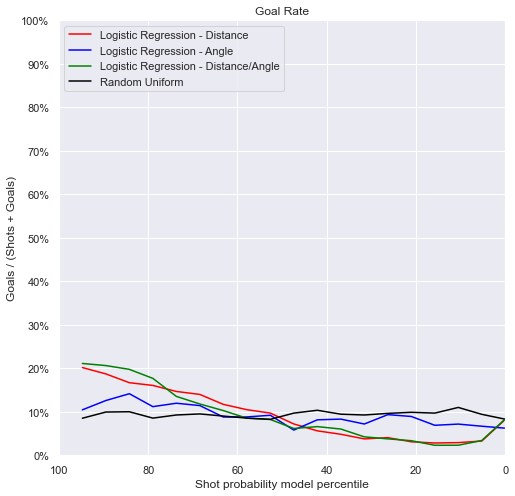

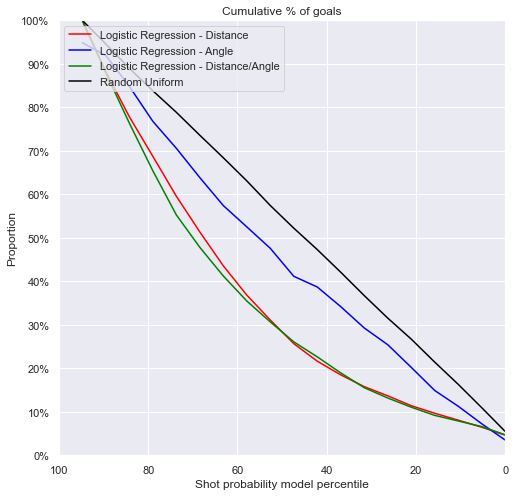

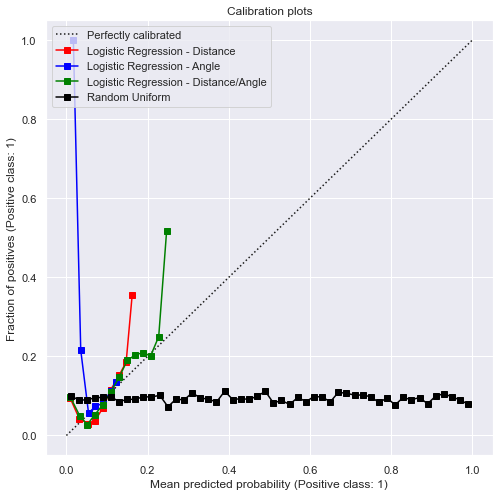

In [159]:
clean_data = features_data[['Shot distance', 'Shot angle', 'Is Goal']].dropna()

X = clean_data[['Shot distance', 'Shot angle']]
y = clean_data['Is Goal']

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=SEED, stratify=y)

# Logistic Regression - Distance only
X_distance_train = X_train[['Shot distance']]
X_distance_valid = X_valid[['Shot distance']]
clf_distance = LogisticRegression(random_state=SEED).fit(X_distance_train, y_train)


# Logistic Regression - Angle only
X_angle_train = X_train[['Shot angle']]
X_angle_valid = X_valid[['Shot angle']]
clf_angle = LogisticRegression(random_state=SEED).fit(X_angle_train, y_train)

# Logistic Regression - Distance and Angle
clf_distance_angle = LogisticRegression(random_state=SEED).fit(X_train, y_train)

classifiers = [(clf_distance, 'Logistic Regression - Distance', X_distance_valid, y_valid),
               (clf_angle, 'Logistic Regression - Angle', X_angle_valid, y_valid),
               (clf_distance_angle, 'Logistic Regression - Distance/Angle', X_valid, y_valid) ]


VizManager.plot_all_figures(classifiers, add_random=True)
